In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image
import warnings


In [2]:
#hyper params
lr = 1e-3
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 60
hardness_threshold = 0.60
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4
classes = ['IRRELEVANT', 'RELEVANT'] #arranged in order of their placement in the folder
num_classes = len(classes)
path = './Balanced_Binary_Dataset'


In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3,sigma=1.5)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:

def get_dataset(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [6]:
def train_model(trainset,valset, model, criterion, optimizer, scheduler_train , scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset, batch_size=bs, shuffle=True)
    }

    dataset_sizes_strong = {'train': len(trainset), 'val': len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    E_accuracy_train = []
    E_accuracy_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for inputs, labels in dataloaders_strong[phase]:
                inputs = inputs.to(device)                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # AdaMatch steps
                    if phase == 'train':
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())


                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                                                
                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs = inputs[skip_mask]
                            labels = labels[skip_mask]
                            preds = preds[skip_mask]
                            loss = criterion(outputs[skip_mask], preds)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                print()

                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
                print('Number of skipped:', c)
                print()
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                entropy_values_train.append(epoch_entropy.item())
                E_loss_train.append(epoch_loss)
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
                E_accuracy_train.append(epoch_acc)
            else:
                entropy_values_val.append(epoch_entropy.item())
                E_loss_val.append(epoch_loss)
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation
                E_accuracy_val.append(epoch_acc)


            
            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            
            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch_val = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val,
        E_accuracy_train,
        E_accuracy_val
    )
  

In [7]:
def test_model(model, testset, hardness_threshold):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

         # Calculate hardness score for each sample in the batch
            probabilities_hard = torch.softmax(outputs, dim=1)
            hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

            # Skip predictions if hardness score is greater than the threshold
            skip_mask = hardness_scores <= hardness_threshold
                    
                    
            if skip_mask.sum().item() > 0:
                c += 1
                inputs = inputs[skip_mask]
                labels = labels[skip_mask]
                preds = preds[skip_mask]
                
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / (len(testset)-c)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)
    print("Skipped Inputs:", c)
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [8]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [9]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = models.vit_b_16(weights = models.ViT_B_16_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft, requires_grad=use_pretrained)
        #num_features = model_ft.fc.in_features
        #model_ft.fc = nn.Sequential(
                   # nn.Linear(num_features, 512),
                    #nn.ReLU(),
                    #nn.Linear(512, num_classes)
                    #)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [13]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [14]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Separate the train, val, and test sets
trainset,valset,testset = get_dataset(path, val_size, test_size)

train : 21068 val : 5267 test : 4648


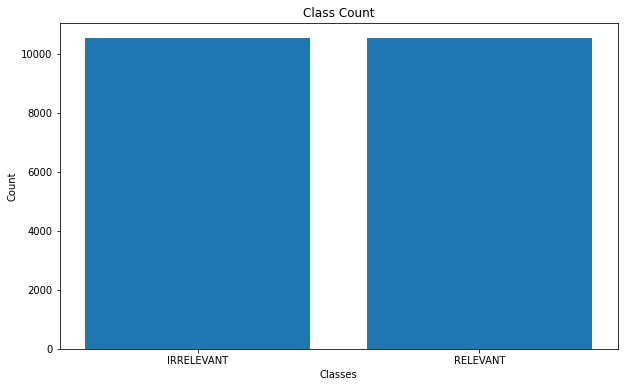

In [22]:
plot_distribution_by_class(trainset, classes)

densenet


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

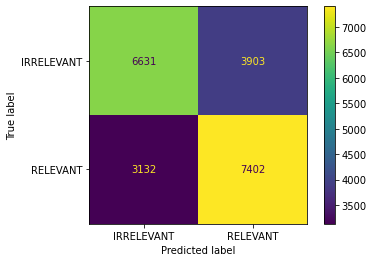

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.4235 Acc: 0.7648
val Epoch Entropy: 0.9132
val Balanced Accuracy: 1.0000



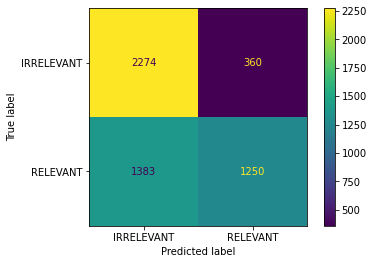

<Figure size 576x432 with 0 Axes>

Epoch 1/59
----------

train Loss: 0.5826 Acc: 0.6968
train Epoch Entropy: 0.8121
train Balanced Accuracy: 0.8333



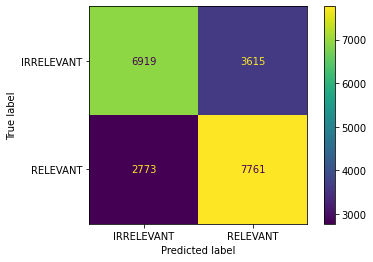

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.4374 Acc: 0.7982
val Epoch Entropy: 0.9464
val Balanced Accuracy: 1.0000



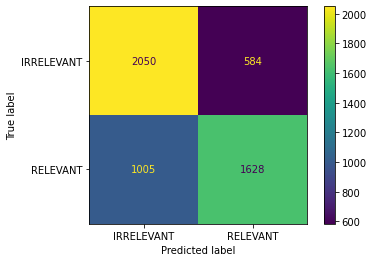

<Figure size 576x432 with 0 Axes>

Epoch 2/59
----------

train Loss: 0.5598 Acc: 0.7124
train Epoch Entropy: 0.7888
train Balanced Accuracy: 0.2500



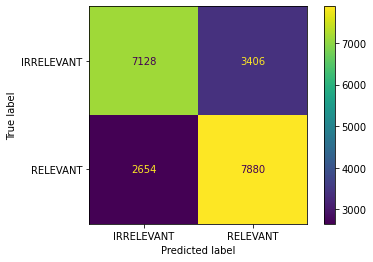

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3691 Acc: 0.8283
val Epoch Entropy: 0.8821
val Balanced Accuracy: 1.0000



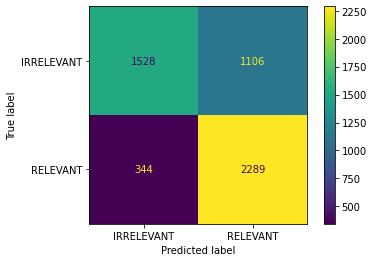

<Figure size 576x432 with 0 Axes>

Epoch 3/59
----------

train Loss: 0.5477 Acc: 0.7241
train Epoch Entropy: 0.7797
train Balanced Accuracy: 0.7500



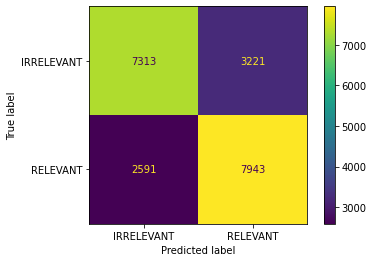

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.4000 Acc: 0.8385
val Epoch Entropy: 0.9091
val Balanced Accuracy: 0.3333



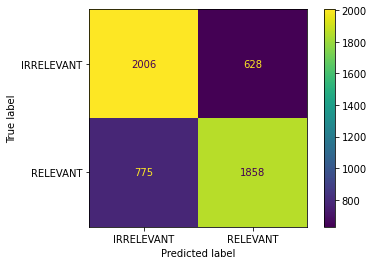

<Figure size 576x432 with 0 Axes>

Epoch 4/59
----------

train Loss: 0.5397 Acc: 0.7310
train Epoch Entropy: 0.7729
train Balanced Accuracy: 0.8333



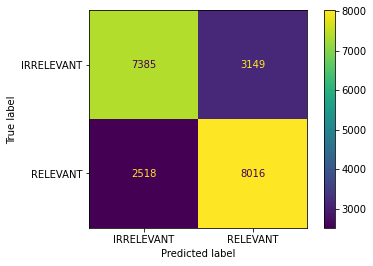

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3380 Acc: 0.8409
val Epoch Entropy: 0.8375
val Balanced Accuracy: 0.7500



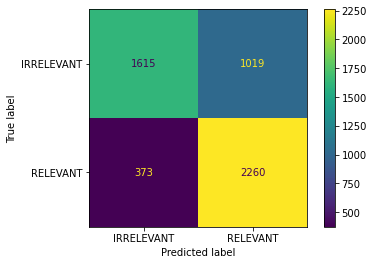

<Figure size 576x432 with 0 Axes>

Epoch 5/59
----------

train Loss: 0.5316 Acc: 0.7350
train Epoch Entropy: 0.7608
train Balanced Accuracy: 1.0000



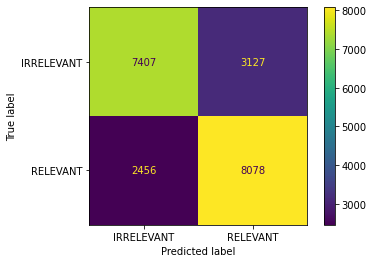

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.2977 Acc: 0.8364
val Epoch Entropy: 0.7731
val Balanced Accuracy: 1.0000



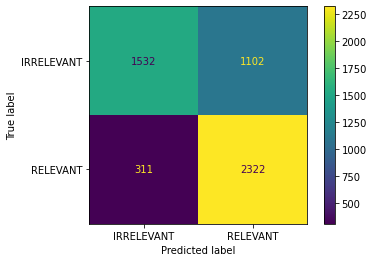

<Figure size 576x432 with 0 Axes>

Epoch 6/59
----------

train Loss: 0.5251 Acc: 0.7416
train Epoch Entropy: 0.7530
train Balanced Accuracy: 0.7500



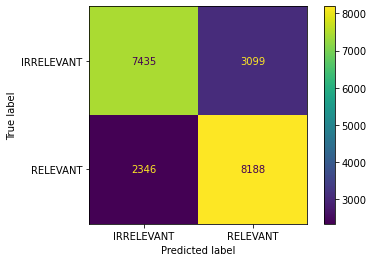

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3615 Acc: 0.8546
val Epoch Entropy: 0.8577
val Balanced Accuracy: 0.7500



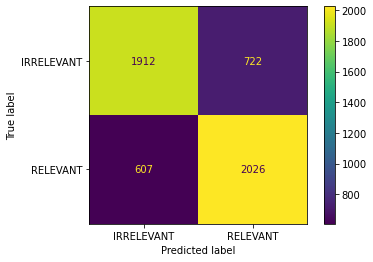

<Figure size 576x432 with 0 Axes>

Epoch 7/59
----------

train Loss: 0.5209 Acc: 0.7437
train Epoch Entropy: 0.7458
train Balanced Accuracy: 0.1667



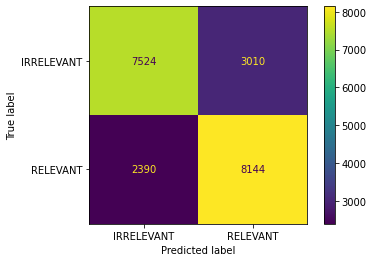

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3652 Acc: 0.8520
val Epoch Entropy: 0.8670
val Balanced Accuracy: 1.0000



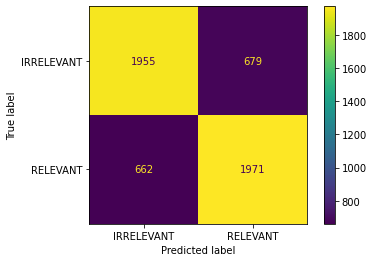

<Figure size 576x432 with 0 Axes>

Epoch 8/59
----------

train Loss: 0.5173 Acc: 0.7465
train Epoch Entropy: 0.7434
train Balanced Accuracy: 0.5000



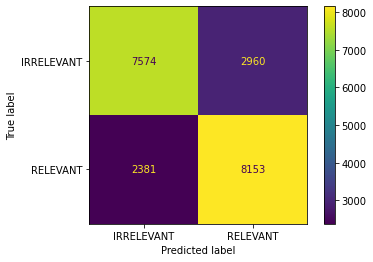

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3740 Acc: 0.8318
val Epoch Entropy: 0.8681
val Balanced Accuracy: 0.5000



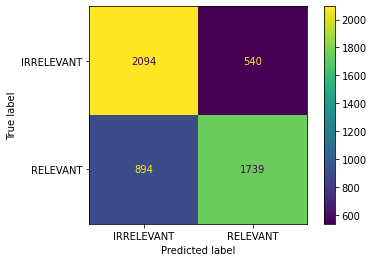

<Figure size 576x432 with 0 Axes>

Epoch 9/59
----------

train Loss: 0.4998 Acc: 0.7552
train Epoch Entropy: 0.7338
train Balanced Accuracy: 0.1667



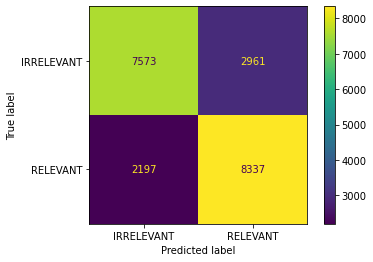

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3444 Acc: 0.8624
val Epoch Entropy: 0.8322
val Balanced Accuracy: 1.0000



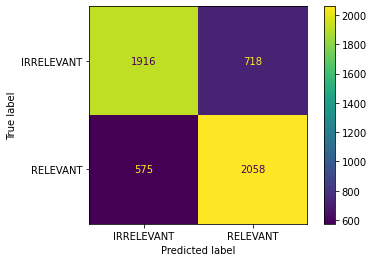

<Figure size 576x432 with 0 Axes>

Epoch 10/59
----------

train Loss: 0.4942 Acc: 0.7601
train Epoch Entropy: 0.7242
train Balanced Accuracy: 0.8333



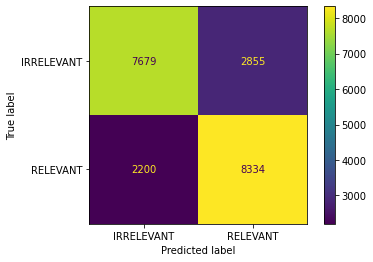

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3118 Acc: 0.8574
val Epoch Entropy: 0.7867
val Balanced Accuracy: 0.3333



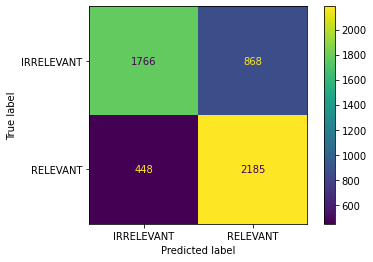

<Figure size 576x432 with 0 Axes>

Epoch 11/59
----------

train Loss: 0.4905 Acc: 0.7583
train Epoch Entropy: 0.7158
train Balanced Accuracy: 1.0000



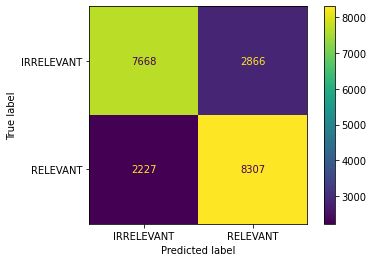

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3157 Acc: 0.8676
val Epoch Entropy: 0.7890
val Balanced Accuracy: 0.3333



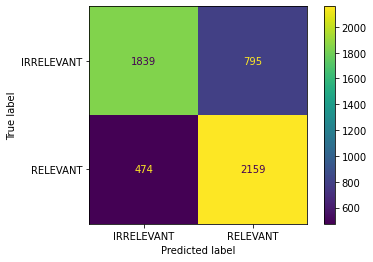

<Figure size 576x432 with 0 Axes>

Epoch 12/59
----------

train Loss: 0.4886 Acc: 0.7605
train Epoch Entropy: 0.7132
train Balanced Accuracy: 1.0000



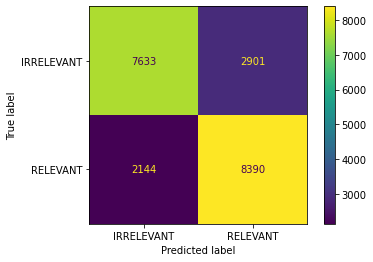

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3344 Acc: 0.8594
val Epoch Entropy: 0.8095
val Balanced Accuracy: 1.0000



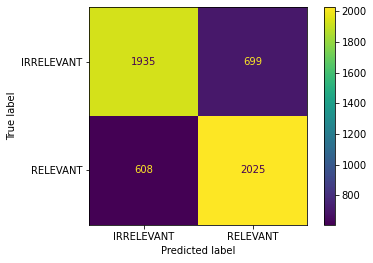

<Figure size 576x432 with 0 Axes>

Epoch 13/59
----------

train Loss: 0.4881 Acc: 0.7624
train Epoch Entropy: 0.7116
train Balanced Accuracy: 0.5000



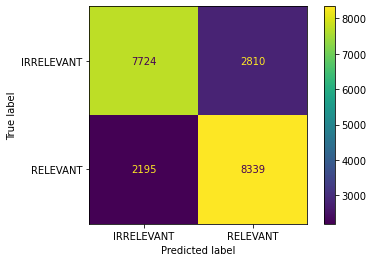

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3178 Acc: 0.8674
val Epoch Entropy: 0.7895
val Balanced Accuracy: 0.5000



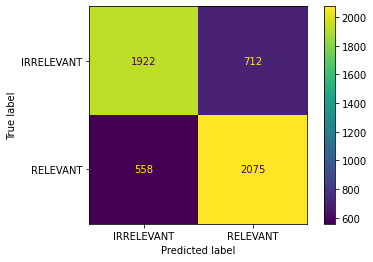

<Figure size 576x432 with 0 Axes>

Epoch 14/59
----------

train Loss: 0.4863 Acc: 0.7615
train Epoch Entropy: 0.7105
train Balanced Accuracy: 0.5000



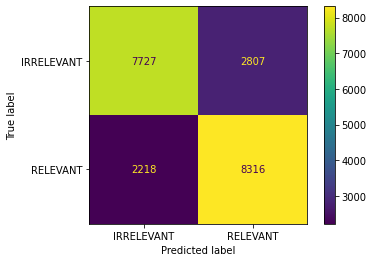

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3253 Acc: 0.8687
val Epoch Entropy: 0.8010
val Balanced Accuracy: 0.7500



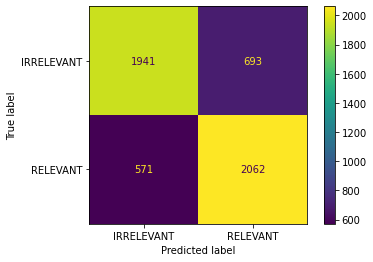

<Figure size 576x432 with 0 Axes>

Epoch 15/59
----------

train Loss: 0.4863 Acc: 0.7628
train Epoch Entropy: 0.7096
train Balanced Accuracy: 0.5000



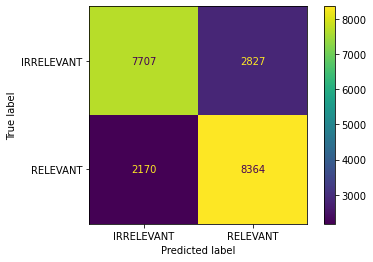

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3378 Acc: 0.8665
val Epoch Entropy: 0.8132
val Balanced Accuracy: 1.0000



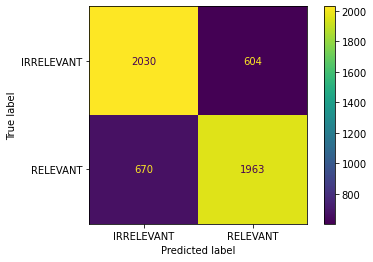

<Figure size 576x432 with 0 Axes>

Epoch 16/59
----------

train Loss: 0.4863 Acc: 0.7646
train Epoch Entropy: 0.7103
train Balanced Accuracy: 1.0000



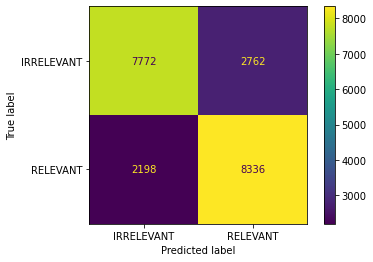

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3200 Acc: 0.8663
val Epoch Entropy: 0.7911
val Balanced Accuracy: 0.6667



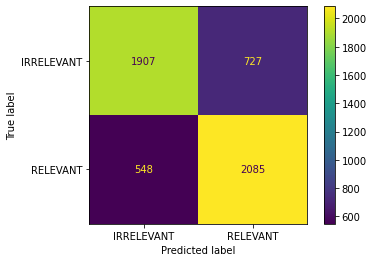

<Figure size 576x432 with 0 Axes>

Epoch 17/59
----------

train Loss: 0.4851 Acc: 0.7641
train Epoch Entropy: 0.7094
train Balanced Accuracy: 1.0000



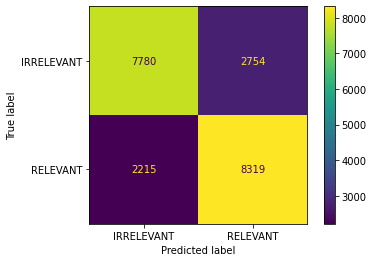

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3230 Acc: 0.8655
val Epoch Entropy: 0.7960
val Balanced Accuracy: 1.0000



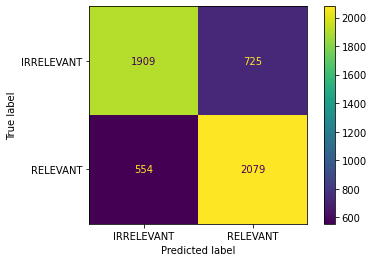

<Figure size 576x432 with 0 Axes>

Epoch 18/59
----------

train Loss: 0.4868 Acc: 0.7637
train Epoch Entropy: 0.7086
train Balanced Accuracy: 0.5000



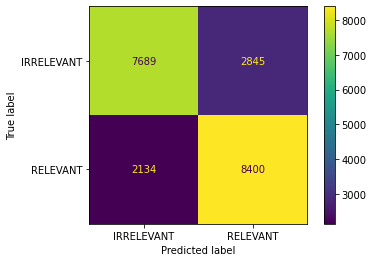

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3177 Acc: 0.8707
val Epoch Entropy: 0.7918
val Balanced Accuracy: 0.7500



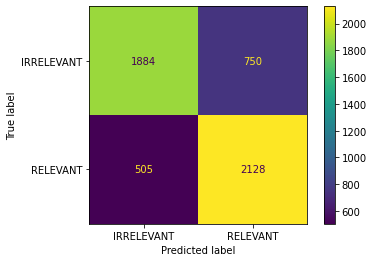

<Figure size 576x432 with 0 Axes>

Epoch 19/59
----------

train Loss: 0.4857 Acc: 0.7657
train Epoch Entropy: 0.7094
train Balanced Accuracy: 1.0000



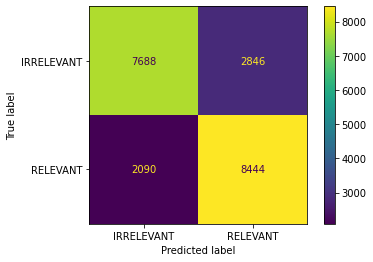

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3352 Acc: 0.8689
val Epoch Entropy: 0.8112
val Balanced Accuracy: 1.0000



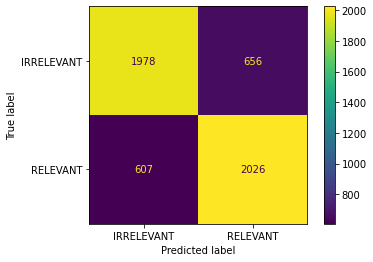

<Figure size 576x432 with 0 Axes>

Epoch 20/59
----------

train Loss: 0.4836 Acc: 0.7662
train Epoch Entropy: 0.7073
train Balanced Accuracy: 0.7500



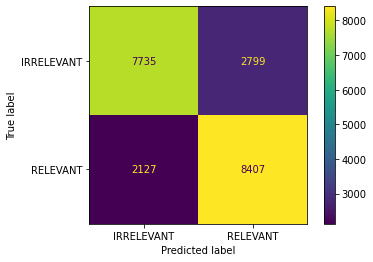

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3243 Acc: 0.8659
val Epoch Entropy: 0.7988
val Balanced Accuracy: 1.0000



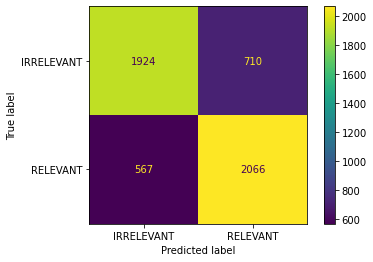

<Figure size 576x432 with 0 Axes>

Epoch 21/59
----------

train Loss: 0.4849 Acc: 0.7638
train Epoch Entropy: 0.7076
train Balanced Accuracy: 0.8333



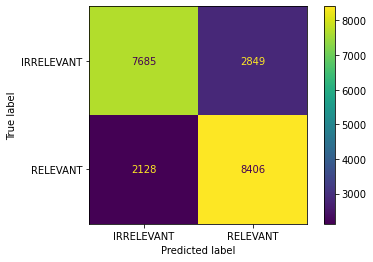

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3315 Acc: 0.8672
val Epoch Entropy: 0.8081
val Balanced Accuracy: 0.7500



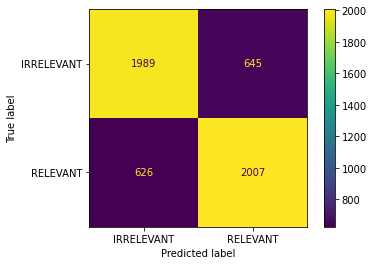

<Figure size 576x432 with 0 Axes>

Epoch 22/59
----------

train Loss: 0.4858 Acc: 0.7614
train Epoch Entropy: 0.7096
train Balanced Accuracy: 0.3333



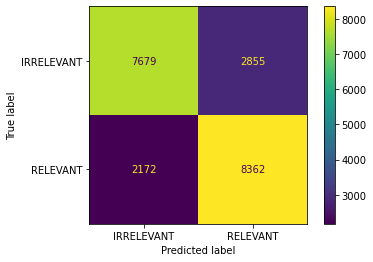

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3222 Acc: 0.8676
val Epoch Entropy: 0.7954
val Balanced Accuracy: 1.0000



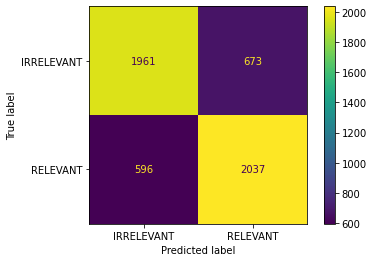

<Figure size 576x432 with 0 Axes>

Epoch 23/59
----------

train Loss: 0.4862 Acc: 0.7648
train Epoch Entropy: 0.7087
train Balanced Accuracy: 0.7500



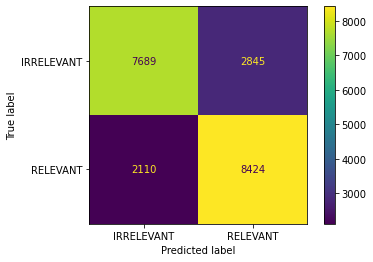

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3247 Acc: 0.8694
val Epoch Entropy: 0.7979
val Balanced Accuracy: 1.0000



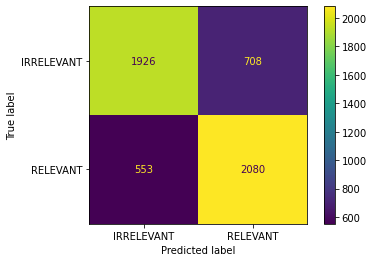

<Figure size 576x432 with 0 Axes>

Epoch 24/59
----------

train Loss: 0.4870 Acc: 0.7635
train Epoch Entropy: 0.7081
train Balanced Accuracy: 0.5000



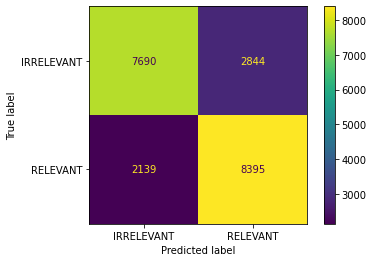

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3266 Acc: 0.8715
val Epoch Entropy: 0.8004
val Balanced Accuracy: 0.2500



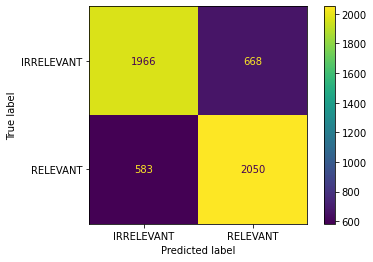

<Figure size 576x432 with 0 Axes>

Epoch 25/59
----------

train Loss: 0.4853 Acc: 0.7637
train Epoch Entropy: 0.7088
train Balanced Accuracy: 1.0000



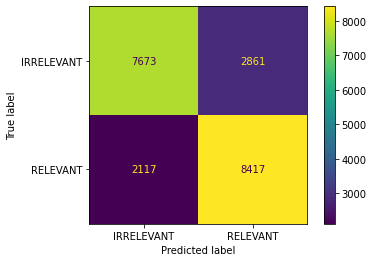

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3309 Acc: 0.8685
val Epoch Entropy: 0.8036
val Balanced Accuracy: 0.7500



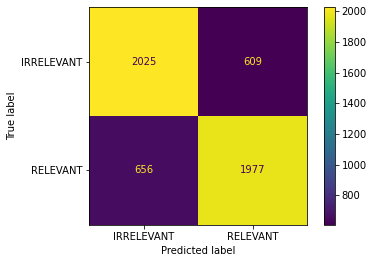

<Figure size 576x432 with 0 Axes>

Epoch 26/59
----------

train Loss: 0.4859 Acc: 0.7653
train Epoch Entropy: 0.7077
train Balanced Accuracy: 0.8333



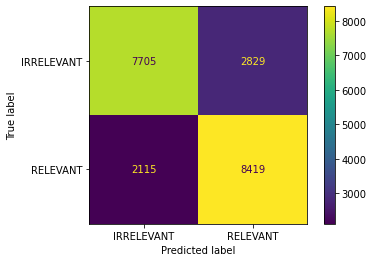

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3197 Acc: 0.8694
val Epoch Entropy: 0.7915
val Balanced Accuracy: 1.0000



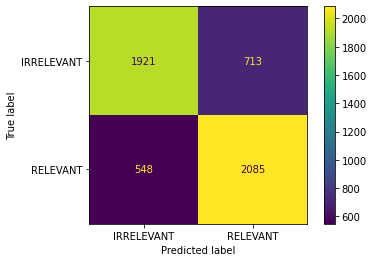

<Figure size 576x432 with 0 Axes>

Epoch 27/59
----------

train Loss: 0.4846 Acc: 0.7622
train Epoch Entropy: 0.7080
train Balanced Accuracy: 1.0000



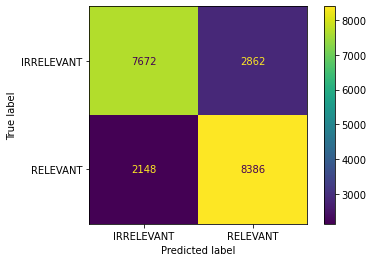

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3317 Acc: 0.8689
val Epoch Entropy: 0.8071
val Balanced Accuracy: 0.7500



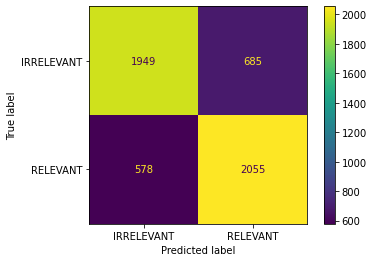

<Figure size 576x432 with 0 Axes>

Epoch 28/59
----------

train Loss: 0.4849 Acc: 0.7641
train Epoch Entropy: 0.7089
train Balanced Accuracy: 0.5000



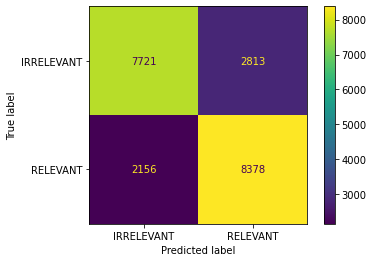

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3204 Acc: 0.8678
val Epoch Entropy: 0.7928
val Balanced Accuracy: 1.0000



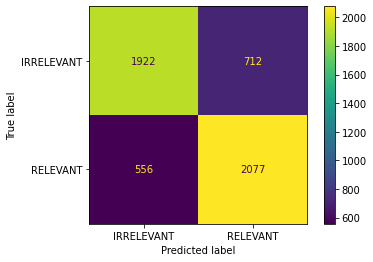

<Figure size 576x432 with 0 Axes>

Epoch 29/59
----------

train Loss: 0.4847 Acc: 0.7640
train Epoch Entropy: 0.7088
train Balanced Accuracy: 0.5000



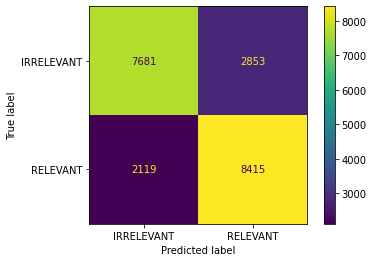

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3298 Acc: 0.8687
val Epoch Entropy: 0.8031
val Balanced Accuracy: 1.0000



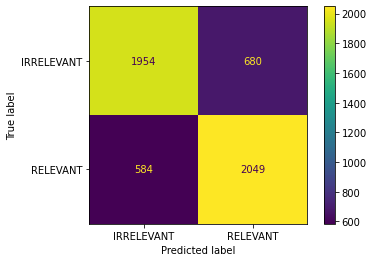

<Figure size 576x432 with 0 Axes>

Epoch 30/59
----------

train Loss: 0.4850 Acc: 0.7655
train Epoch Entropy: 0.7080
train Balanced Accuracy: 0.7500



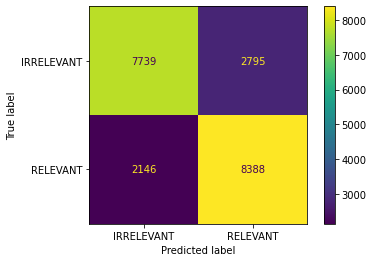

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3195 Acc: 0.8648
val Epoch Entropy: 0.7939
val Balanced Accuracy: 0.2500



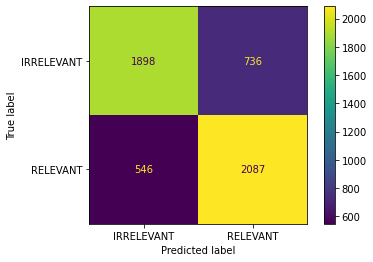

<Figure size 576x432 with 0 Axes>

Epoch 31/59
----------

train Loss: 0.4853 Acc: 0.7648
train Epoch Entropy: 0.7088
train Balanced Accuracy: 0.5000



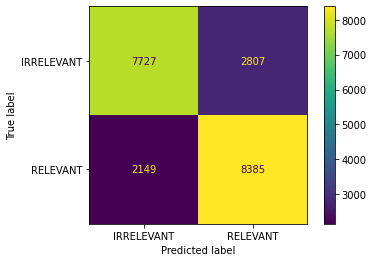

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3182 Acc: 0.8674
val Epoch Entropy: 0.7890
val Balanced Accuracy: 0.7500



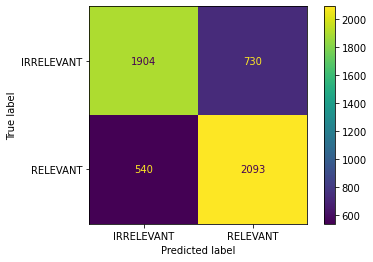

<Figure size 576x432 with 0 Axes>

Epoch 32/59
----------

train Loss: 0.4858 Acc: 0.7637
train Epoch Entropy: 0.7079
train Balanced Accuracy: 0.8333



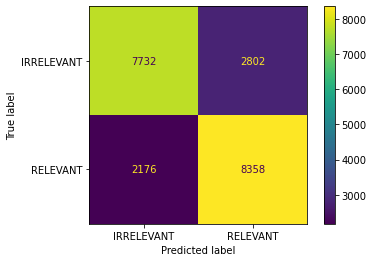

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3202 Acc: 0.8709
val Epoch Entropy: 0.7894
val Balanced Accuracy: 0.2500



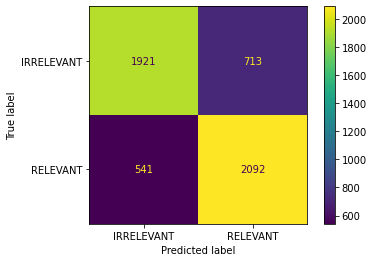

<Figure size 576x432 with 0 Axes>

Epoch 33/59
----------

train Loss: 0.4851 Acc: 0.7643
train Epoch Entropy: 0.7082
train Balanced Accuracy: 1.0000



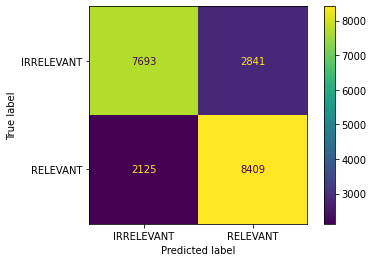

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3191 Acc: 0.8707
val Epoch Entropy: 0.7864
val Balanced Accuracy: 0.7500



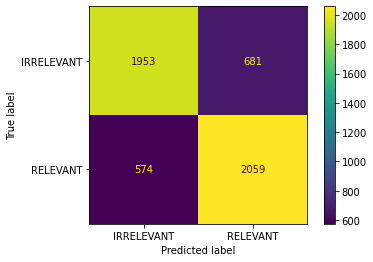

<Figure size 576x432 with 0 Axes>

Epoch 34/59
----------

train Loss: 0.4853 Acc: 0.7665
train Epoch Entropy: 0.7088
train Balanced Accuracy: 0.5000



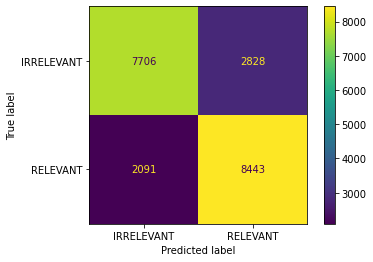

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3170 Acc: 0.8637
val Epoch Entropy: 0.7873
val Balanced Accuracy: 0.6667



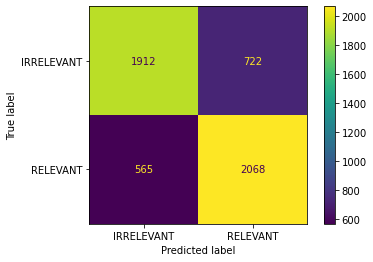

<Figure size 576x432 with 0 Axes>

Epoch 35/59
----------

train Loss: 0.4855 Acc: 0.7652
train Epoch Entropy: 0.7087
train Balanced Accuracy: 1.0000



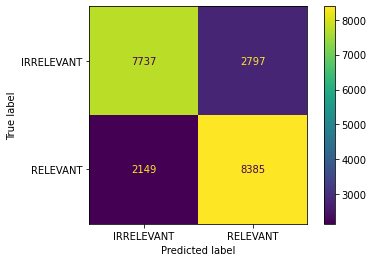

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3232 Acc: 0.8681
val Epoch Entropy: 0.7973
val Balanced Accuracy: 0.2500



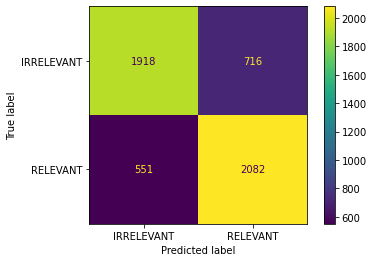

<Figure size 576x432 with 0 Axes>

Epoch 36/59
----------

train Loss: 0.4848 Acc: 0.7621
train Epoch Entropy: 0.7101
train Balanced Accuracy: 0.6667



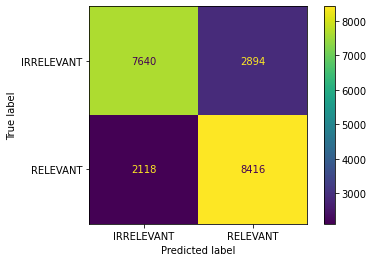

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3203 Acc: 0.8639
val Epoch Entropy: 0.7914
val Balanced Accuracy: 1.0000



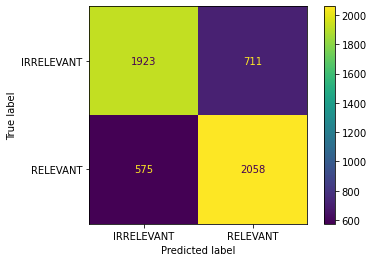

<Figure size 576x432 with 0 Axes>

Epoch 37/59
----------

train Loss: 0.4878 Acc: 0.7635
train Epoch Entropy: 0.7086
train Balanced Accuracy: 0.8333



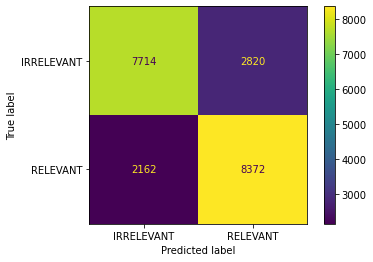

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3289 Acc: 0.8728
val Epoch Entropy: 0.8034
val Balanced Accuracy: 0.6667



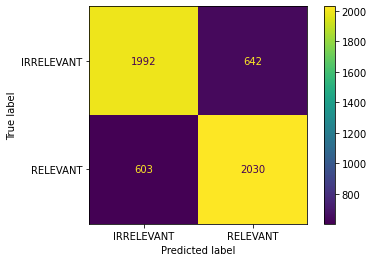

<Figure size 576x432 with 0 Axes>

Epoch 38/59
----------

train Loss: 0.4868 Acc: 0.7637
train Epoch Entropy: 0.7085
train Balanced Accuracy: 0.7500



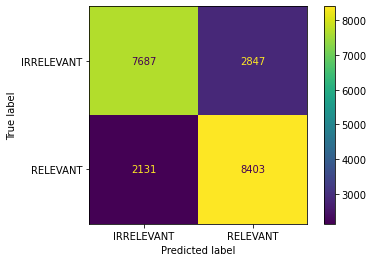

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3157 Acc: 0.8676
val Epoch Entropy: 0.7846
val Balanced Accuracy: 1.0000



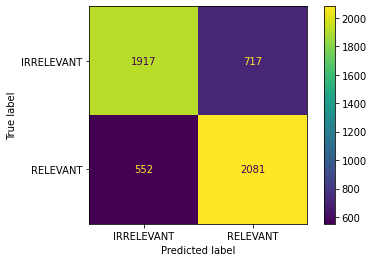

<Figure size 576x432 with 0 Axes>

Epoch 39/59
----------

train Loss: 0.4859 Acc: 0.7611
train Epoch Entropy: 0.7084
train Balanced Accuracy: 0.6667



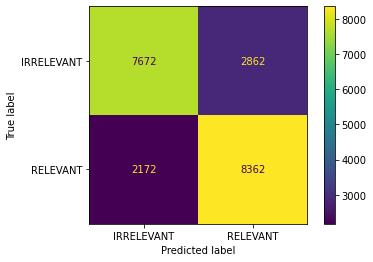

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3140 Acc: 0.8674
val Epoch Entropy: 0.7860
val Balanced Accuracy: 1.0000



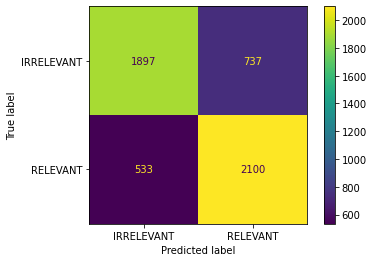

<Figure size 576x432 with 0 Axes>

Epoch 40/59
----------

train Loss: 0.4853 Acc: 0.7652
train Epoch Entropy: 0.7084
train Balanced Accuracy: 1.0000



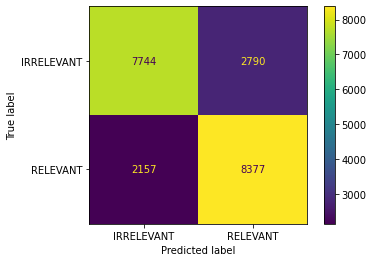

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3071 Acc: 0.8711
val Epoch Entropy: 0.7734
val Balanced Accuracy: 0.6667



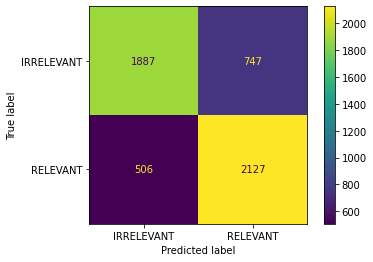

<Figure size 576x432 with 0 Axes>

Epoch 41/59
----------

train Loss: 0.4838 Acc: 0.7653
train Epoch Entropy: 0.7080
train Balanced Accuracy: 1.0000



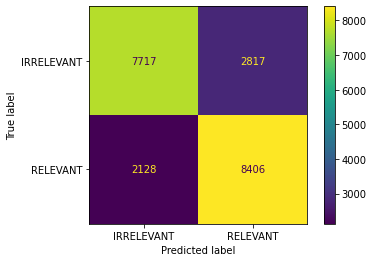

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3231 Acc: 0.8637
val Epoch Entropy: 0.7949
val Balanced Accuracy: 0.7500



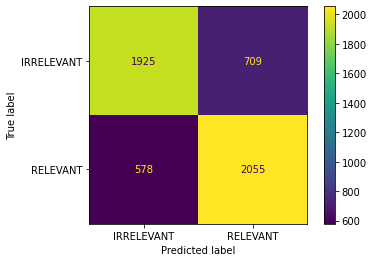

<Figure size 576x432 with 0 Axes>

Epoch 42/59
----------

train Loss: 0.4853 Acc: 0.7637
train Epoch Entropy: 0.7085
train Balanced Accuracy: 0.3333



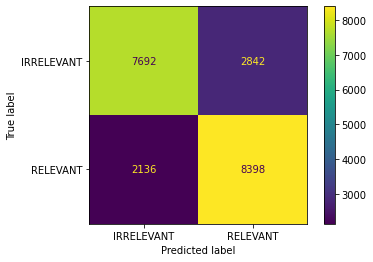

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3247 Acc: 0.8711
val Epoch Entropy: 0.7972
val Balanced Accuracy: 0.6667



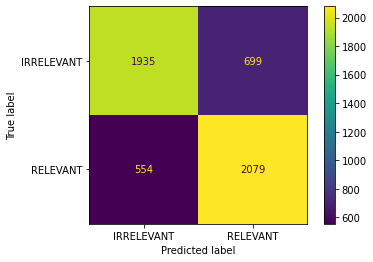

<Figure size 576x432 with 0 Axes>

Epoch 43/59
----------

train Loss: 0.4848 Acc: 0.7652
train Epoch Entropy: 0.7090
train Balanced Accuracy: 0.3333



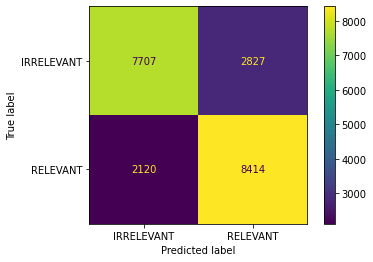

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3257 Acc: 0.8624
val Epoch Entropy: 0.8011
val Balanced Accuracy: 1.0000



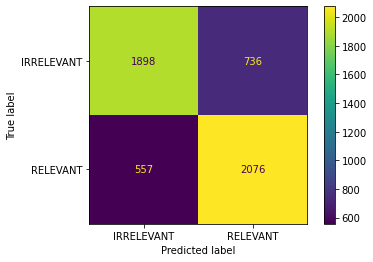

<Figure size 576x432 with 0 Axes>

Epoch 44/59
----------

train Loss: 0.4861 Acc: 0.7628
train Epoch Entropy: 0.7089
train Balanced Accuracy: 0.8333



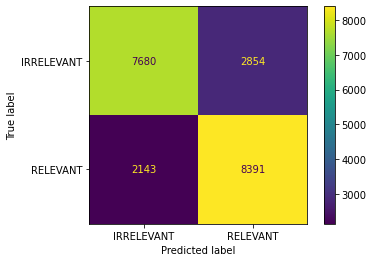

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3219 Acc: 0.8681
val Epoch Entropy: 0.7978
val Balanced Accuracy: 0.7500



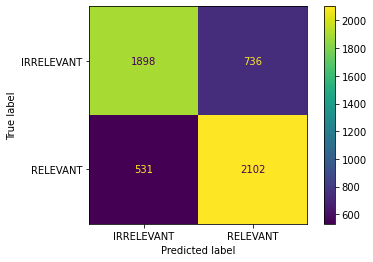

<Figure size 576x432 with 0 Axes>

Epoch 45/59
----------

train Loss: 0.4845 Acc: 0.7655
train Epoch Entropy: 0.7076
train Balanced Accuracy: 1.0000



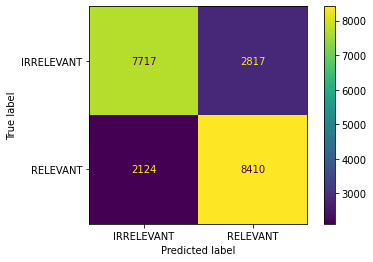

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3292 Acc: 0.8700
val Epoch Entropy: 0.8039
val Balanced Accuracy: 0.6667



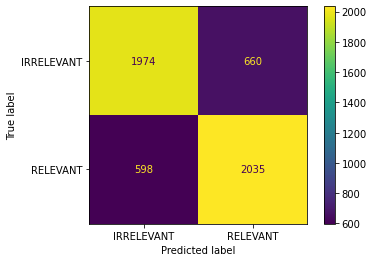

<Figure size 576x432 with 0 Axes>

Epoch 46/59
----------

train Loss: 0.4875 Acc: 0.7633
train Epoch Entropy: 0.7109
train Balanced Accuracy: 0.7500



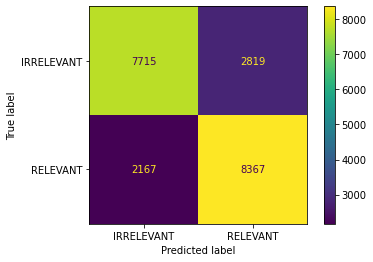

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3214 Acc: 0.8644
val Epoch Entropy: 0.7919
val Balanced Accuracy: 0.2500



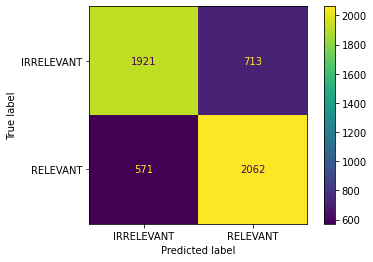

<Figure size 576x432 with 0 Axes>

Epoch 47/59
----------

train Loss: 0.4854 Acc: 0.7639
train Epoch Entropy: 0.7088
train Balanced Accuracy: 1.0000



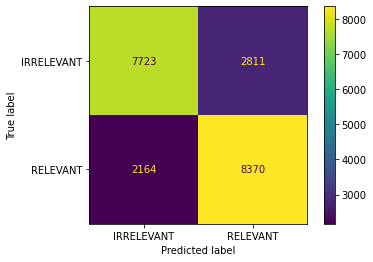

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3266 Acc: 0.8691
val Epoch Entropy: 0.8016
val Balanced Accuracy: 0.2500



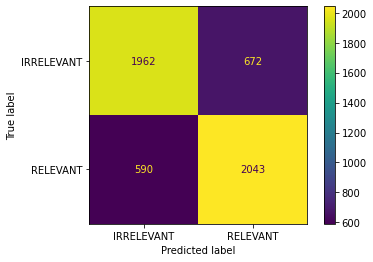

<Figure size 576x432 with 0 Axes>

Epoch 48/59
----------

train Loss: 0.4879 Acc: 0.7618
train Epoch Entropy: 0.7087
train Balanced Accuracy: 1.0000



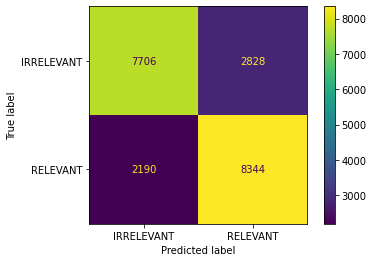

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3227 Acc: 0.8652
val Epoch Entropy: 0.7944
val Balanced Accuracy: 1.0000



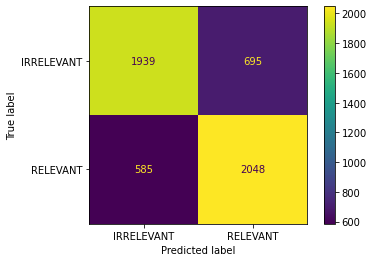

<Figure size 576x432 with 0 Axes>

Epoch 49/59
----------

train Loss: 0.4842 Acc: 0.7644
train Epoch Entropy: 0.7083
train Balanced Accuracy: 1.0000



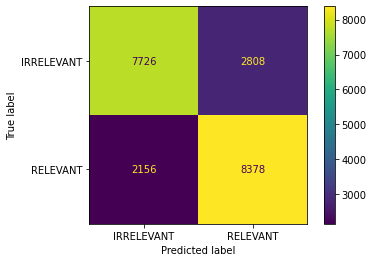

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3293 Acc: 0.8722
val Epoch Entropy: 0.8011
val Balanced Accuracy: 1.0000



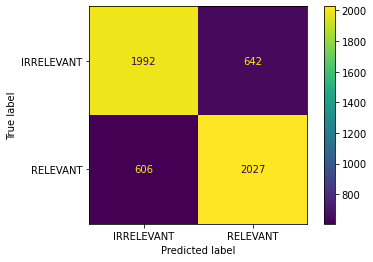

<Figure size 576x432 with 0 Axes>

Epoch 50/59
----------

train Loss: 0.4856 Acc: 0.7634
train Epoch Entropy: 0.7095
train Balanced Accuracy: 0.7500



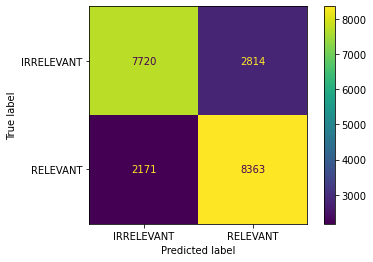

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3175 Acc: 0.8687
val Epoch Entropy: 0.7895
val Balanced Accuracy: 0.5000



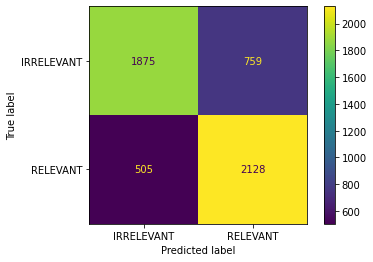

<Figure size 576x432 with 0 Axes>

Epoch 51/59
----------

train Loss: 0.4854 Acc: 0.7650
train Epoch Entropy: 0.7073
train Balanced Accuracy: 0.7500



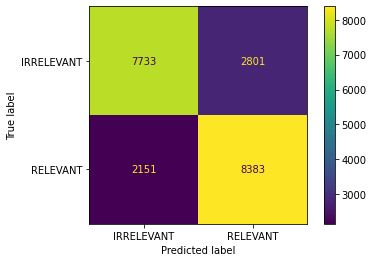

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3220 Acc: 0.8652
val Epoch Entropy: 0.7935
val Balanced Accuracy: 1.0000



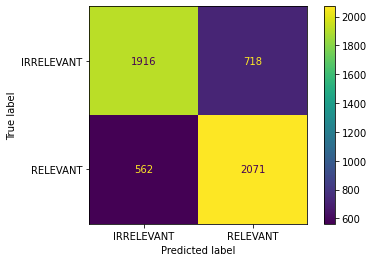

<Figure size 576x432 with 0 Axes>

Epoch 52/59
----------

train Loss: 0.4866 Acc: 0.7633
train Epoch Entropy: 0.7084
train Balanced Accuracy: 0.7500



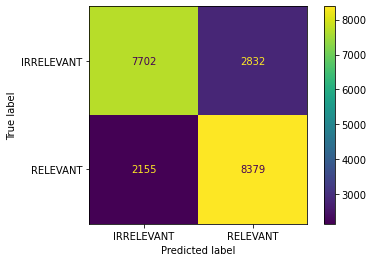

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3271 Acc: 0.8672
val Epoch Entropy: 0.8024
val Balanced Accuracy: 1.0000



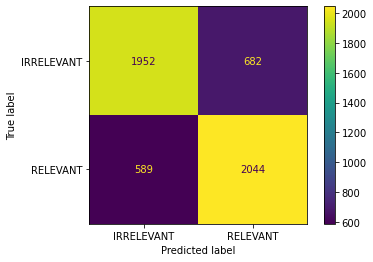

<Figure size 576x432 with 0 Axes>

Epoch 53/59
----------

train Loss: 0.4843 Acc: 0.7653
train Epoch Entropy: 0.7071
train Balanced Accuracy: 0.5000



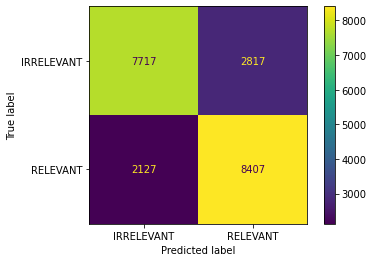

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3265 Acc: 0.8665
val Epoch Entropy: 0.8012
val Balanced Accuracy: 1.0000



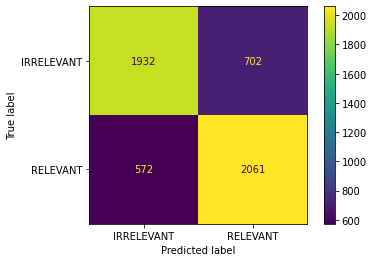

<Figure size 576x432 with 0 Axes>

Epoch 54/59
----------

train Loss: 0.4860 Acc: 0.7617
train Epoch Entropy: 0.7083
train Balanced Accuracy: 0.5000



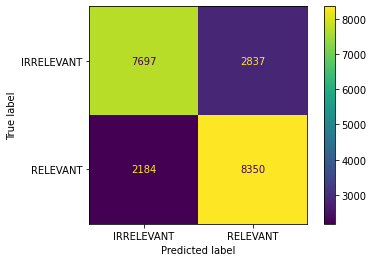

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3338 Acc: 0.8655
val Epoch Entropy: 0.8101
val Balanced Accuracy: 0.7500



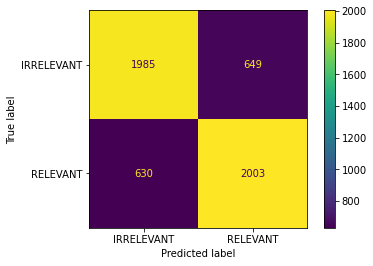

<Figure size 576x432 with 0 Axes>

Epoch 55/59
----------

train Loss: 0.4859 Acc: 0.7641
train Epoch Entropy: 0.7087
train Balanced Accuracy: 1.0000



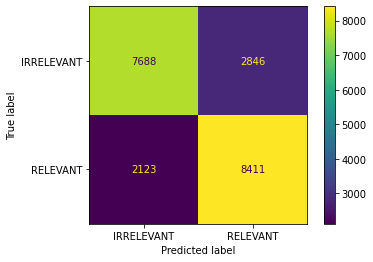

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3331 Acc: 0.8650
val Epoch Entropy: 0.8108
val Balanced Accuracy: 0.2500



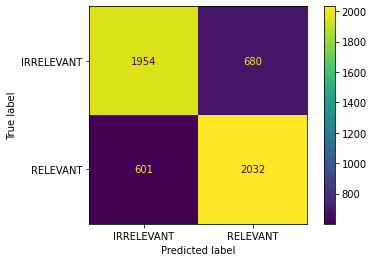

<Figure size 576x432 with 0 Axes>

Epoch 56/59
----------

train Loss: 0.4853 Acc: 0.7629
train Epoch Entropy: 0.7076
train Balanced Accuracy: 0.7500



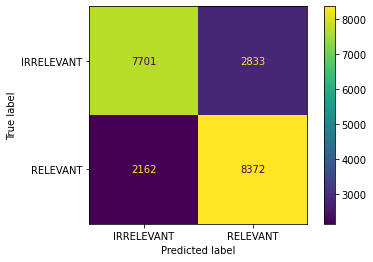

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3109 Acc: 0.8683
val Epoch Entropy: 0.7790
val Balanced Accuracy: 0.7500



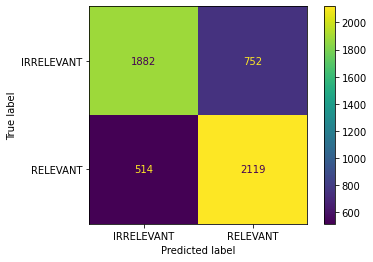

<Figure size 576x432 with 0 Axes>

Epoch 57/59
----------

train Loss: 0.4868 Acc: 0.7631
train Epoch Entropy: 0.7102
train Balanced Accuracy: 1.0000



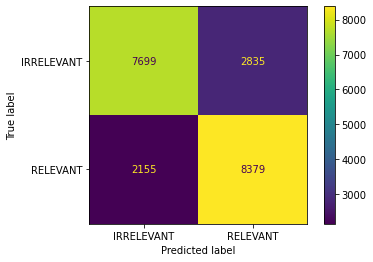

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3217 Acc: 0.8704
val Epoch Entropy: 0.7927
val Balanced Accuracy: 0.2500



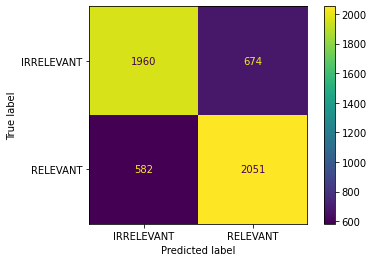

<Figure size 576x432 with 0 Axes>

Epoch 58/59
----------

train Loss: 0.4857 Acc: 0.7659
train Epoch Entropy: 0.7096
train Balanced Accuracy: 0.5000



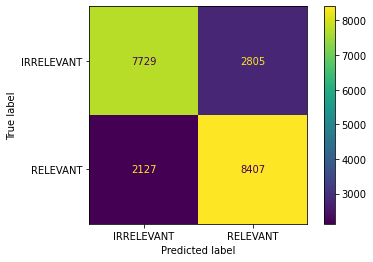

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3297 Acc: 0.8676
val Epoch Entropy: 0.8007
val Balanced Accuracy: 0.6667



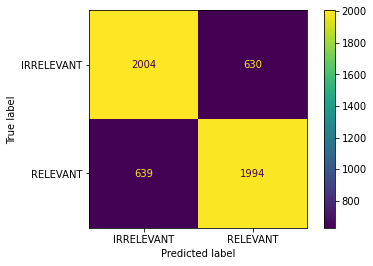

<Figure size 576x432 with 0 Axes>

Epoch 59/59
----------

train Loss: 0.4842 Acc: 0.7650
train Epoch Entropy: 0.7085
train Balanced Accuracy: 0.3333



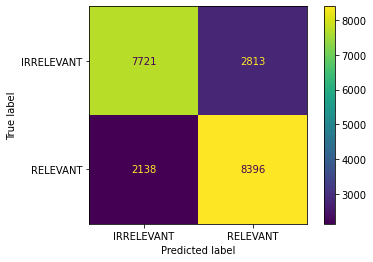

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3155 Acc: 0.8615
val Epoch Entropy: 0.7870
val Balanced Accuracy: 1.0000



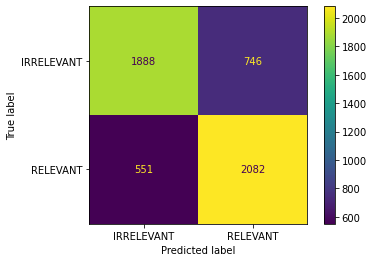

<Figure size 576x432 with 0 Axes>

Training complete in 691m 6s
Best val Acc: 0.872830
Best Val Acc. was achieved at epoch 37


In [15]:
model_list = []

for model_name in ['densenet']:
    
    print(model_name)
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)


    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val,E_accuracy_train,E_accuracy_val = train_model(trainset,valset,model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    
    model_list.append(model)



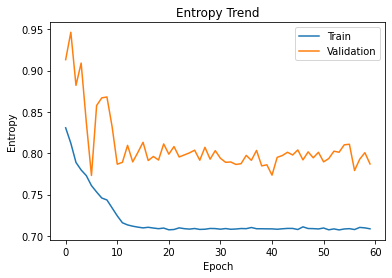

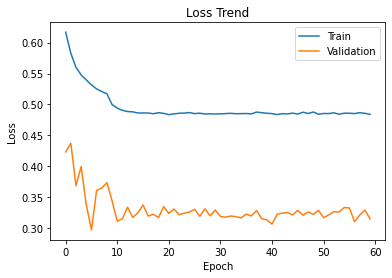

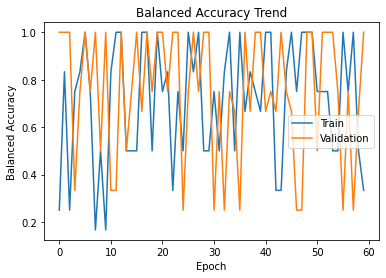

In [16]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Trend')
plt.legend()
plt.show()




In [43]:

# Assuming you have a trained model named "model"


# Define the file path to save the model
model_file1 = './model_state.pt'

# Save the model
torch.save(model.state_dict(), model_file1)

model_file2 = './model_entire.pt'

# Save the entire model
torch.save(model, model_file2)


In [40]:

# Create an instance of the ResNet50 model
model = torch.load('./model_entire.pt')

# Load the state dictionary from the model_state file
state_dict = torch.load('./model_state.pt')

# Load the state dictionary into the model
model.load_state_dict(state_dict)



<All keys matched successfully>

30
The Test Accuracy: tensor(0.8643, device='cuda:0')
The Test Balanced Accuracy: 0.7562392426850257
Skipped Inputs: 581


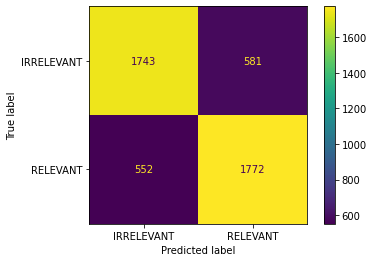

<Figure size 576x432 with 0 Axes>

35
The Test Accuracy: tensor(0.8621, device='cuda:0')
The Test Balanced Accuracy: 0.754302925989673
Skipped Inputs: 581


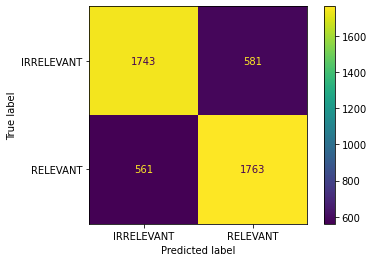

<Figure size 576x432 with 0 Axes>

40
The Test Accuracy: tensor(0.8628, device='cuda:0')
The Test Balanced Accuracy: 0.7549483648881239
Skipped Inputs: 581


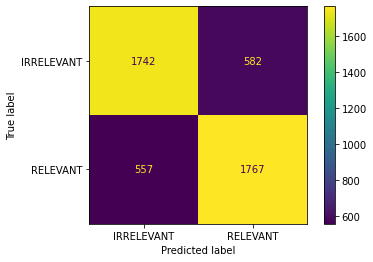

<Figure size 576x432 with 0 Axes>

60
The Test Accuracy: tensor(0.8672, device='cuda:0')
The Test Balanced Accuracy: 0.7588209982788297
Skipped Inputs: 581


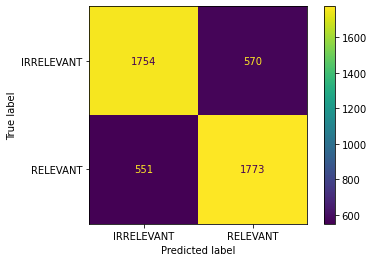

<Figure size 576x432 with 0 Axes>

75
The Test Accuracy: tensor(0.8611, device='cuda:0')
The Test Balanced Accuracy: 0.7534423407917383
Skipped Inputs: 581


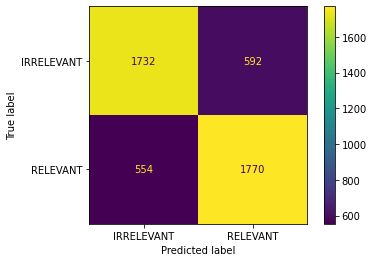

<Figure size 576x432 with 0 Axes>

In [17]:
for model in model_list:
    for hardness_threshold in [30,35,40,60,75]:
        print(hardness_threshold)
        test_model(model, testset, hardness_threshold)


In [13]:


def get_dataset_new(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset



In [24]:
model_list = []
for model_name in ['resnet']:
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    model = model.to(device)
    model_list.append(model)

/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
trainset,valset,testset = get_dataset_new(path, val_size, test_size)

train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

train : 21068 val : 5267 test : 4648


In [26]:
print(len(test_X))

4648


In [27]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.5064543889845095


Accuracy for SVM: 0.5309810671256454
Balanced Accuracy:0.5309810671256454


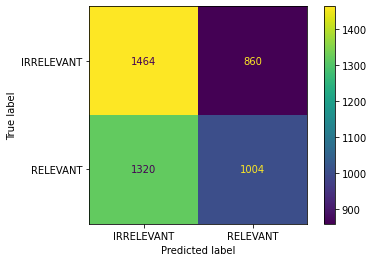

<Figure size 576x432 with 0 Axes>

In [28]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.5299053356282272
Balanced Accuracy:0.5299053356282272


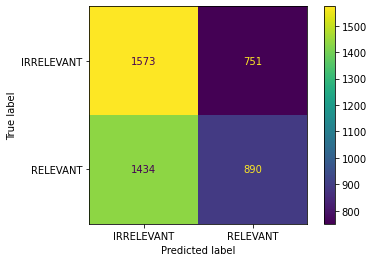

<Figure size 576x432 with 0 Axes>

In [29]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()